## Raspberry Pi Accelerometer Data Analysis Notebook

Post-processes and plots accelerometer data from a file recorded by a Raspberry Pi with the MCC 172 IEPE Measurement DAQ HAT.

### Mandatory File Inputs:
- Raspberry Pi IEPE DAQ HAT Accelerometer File (.lvm or .txt)

### Optional File Inputs:
- LabVIEW Flow Loop File (.lvm)
- PSCS Power Supply Data File (.csv)

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec
import scipy
from scipy import stats
from scipy.signal import welch, stft, spectrogram
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os
from datetime import datetime, timedelta
import re
import pywt
from numpy.fft import rfft, rfftfreq
import copy
import json

mpl.rcParams['agg.path.chunksize'] = 10000000

In [2]:
def is_number(s):
    # Define a regex pattern to match positive, negative, and decimal numbers
    number_pattern = re.compile(r'^-?(\d+(\.\d*)?|\.\d+)$')
    
    # Use the pattern to check if the string matches
    return bool(number_pattern.match(s))

def truncate_microseconds(dt_str):
    # Split the time string at the decimal point
    if '.' in dt_str:
        time_part, microseconds_part = dt_str.split('.')
        # Truncate to only the first six digits of microseconds
        truncated_microseconds_part = microseconds_part[:6]
        truncated_dt_str = f"{time_part}.{truncated_microseconds_part}"
        return truncated_dt_str
    return dt_str

In [3]:
experiment_raw_df = {}
filter_signal = ""

## Import Accelerometer Data Recorded By the Raspberry Pi

In [4]:
accelerometer_filepath = ""
while True:
    # Specify the file path directly
    accelerometer_filename = input("Please enter the name of your accelerometer file: ")
    accelerometer_folder = input("Please enter the full path (not including the filename) to your .lvm or .txt file: ")

    if accelerometer_folder:
        accelerometer_filepath = accelerometer_folder + "\\" + accelerometer_filename
    else: 
        accelerometer_filepath = accelerometer_filename

    print("\Accelerometer Data Filepath: ", accelerometer_filepath)

    if os.path.isfile(accelerometer_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")

\Accelerometer Data Filepath:  C:\Users\sapierso\OneDrive - University of Arkansas\Documents\GitHub\NED3-Flow-Loop-Analysis\accelerometer-raspberry-pi\example-files\FL-102-raspberryPi-accelerometer.csv


In [5]:
def import_csv_to_df(filepath, delimiter=','):
    accelerometer_raw_df = pd.read_csv(filepath, delimiter=delimiter, header=0)  # Assume first line is header
    accelerometer_raw_df = accelerometer_raw_df.dropna(axis=1, how='all')
    return accelerometer_raw_df

accelerometer_raw_df = import_csv_to_df(accelerometer_filepath)

# Define the sample interval (in seconds)
sampling_frequency = 51200  # Hz
sample_interval = 1./sampling_frequency  # s

# Create 'Time (s)' column as a multiplier on the index
time_col_name = 'Time (s)'
accelerometer_raw_df[time_col_name] = accelerometer_raw_df.index * sample_interval

# Reorder the columns to place 'Time (s)' at the front
cols = accelerometer_raw_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Time (s)')))
accelerometer_raw_df = accelerometer_raw_df[cols]

display(accelerometer_raw_df)

,Time (s),Chan 0,Chan 1
0,0.000000,-0.912502,-1.003768
1,0.000020,-0.836249,-0.981843
2,0.000039,-0.917382,-1.109742
3,0.000059,-0.902741,-1.009859
4,0.000078,-0.940563,-0.966008
...,...,...,...
897776,17.534688,0.004971,0.202749
897777,17.534707,-0.011500,0.168643
897778,17.534727,-0.088362,0.231374
897779,17.534746,-0.063961,0.216148


In [6]:
channel_name = "Chan 0"
accelerometer_time = accelerometer_raw_df['Time (s)'].values
sampling_period = accelerometer_time[1] - accelerometer_time[0]
sampling_frequency = 1 / sampling_period
print(f"Sampling Frequency: {sampling_frequency} Hz")

Sampling Frequency: 51200.0 Hz


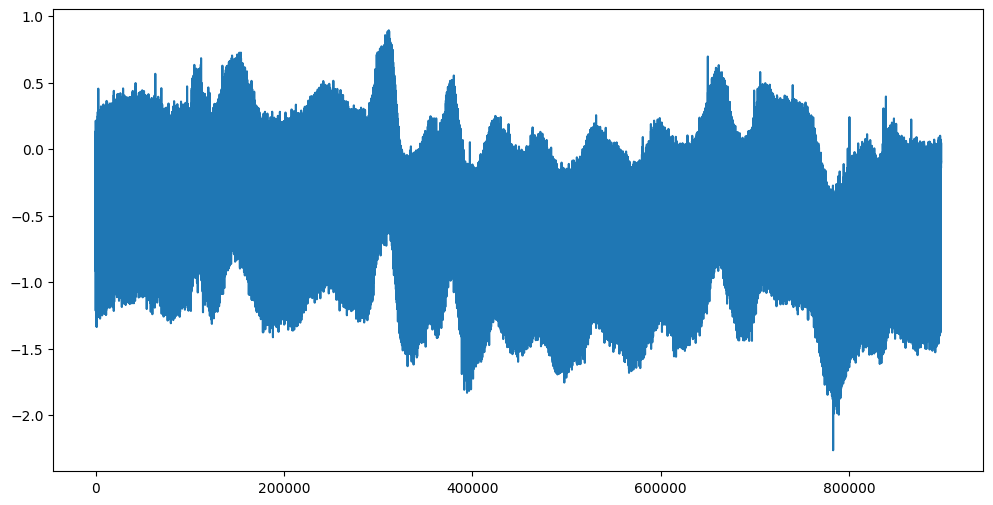

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(accelerometer_raw_df.index, accelerometer_raw_df[channel_name])
plt.show()

## Optionally Import FL Dataframe

In [8]:
skip_FL_import = False
FL_filepath = ""
while True:
    # Specify the file path directly
    FL_filename = input("Please enter the name of your flow loop .lvm or .txt file (Enter 'None' to skip file import): ")
    folder = input("Please enter the full path (not including the filename) to your .lvm or .txt file: ")
    if FL_filename.strip().lower() == 'none':
        skip_FL_import = True
        break

    if folder:
        FL_filepath = folder + "\\" + FL_filename
    else: 
        FL_filepath = FL_filename

    print("\nFlow Loop Data Filepath: ", FL_filepath)

    if os.path.isfile(FL_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")


Flow Loop Data Filepath:  C:\Users\sapierso\OneDrive - University of Arkansas\Documents\GitHub\NED3-Flow-Loop-Analysis\accelerometer-raspberry-pi\example-files\FL-102-flow-loop.lvm


In [9]:
def get_lvm_metadata(filepath):
    header_found = False
    metadata = {}
    with open(filepath, 'r') as file:
        for line in file:
            if header_found:
                if line.startswith("Time"):
                    current_line = line
                    # Split the line to extract the datetime string
                    _ , sensor_start_times_str = current_line.split('\t',1)
                    sensor_start_times = sensor_start_times_str.split('\t')
                    start_time = sensor_start_times[0]
                    start_time_trunc = truncate_microseconds(start_time)
                    lvm_start_time_obj = datetime.strptime(start_time_trunc, "%H:%M:%S.%f")
                    metadata['start_time'] = lvm_start_time_obj
                if line.startswith("Delta_X"):
                    current_line = line
                    # Split the line to extract the datetime string
                    _ , sampling_periods_str = current_line.split('\t',1)
                    sampling_periods = sampling_periods_str.split('\t')
                    metadata['sampling_period'] = float(sampling_periods[0])
                    break
            elif "***End_of_Header***" in line:
                header_found = True
        lines = file.readlines()
        final_line = lines[len(lines)-1]
        experiment_duration, _ = final_line.split("\t",1)
        metadata['duration'] = float(experiment_duration)
        # Iterate through each line in the file
    return metadata
    

def import_lvm_to_df(filepath):
    # Find the second occurrence of the header line containing '***End_of_Header***' which indicates beginning of dataframe
    header_count = 0
    header_line_index = 0
    with open(filepath, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines[:50]):  # Check the first 50 lines
            if '***End_of_Header***' in line:
                header_count += 1
                if header_count == 2:
                    header_line_index = i + 1
                    break

    # Read the file, handling the case where the 2nd header marker is not found
    if header_count == 2:
        raw_df = pd.read_csv(filepath, delimiter='\t', header=header_line_index)
    else:
        raw_df = pd.read_csv(filepath, delimiter='\t', header=0)  # Assume first line is header
    return raw_df

def process_lvm_data(df, metadata):
    lvm_start_time_obj = metadata['start_time']
    
    # Create a timedelta for each row based on seconds
    seconds = df['X_Value']
    time_deltas = pd.to_timedelta(seconds, unit='s')

    # Adding the timedelta to the start time to get the absolute times
    absolute_time = lvm_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    df = df.drop('Comment', axis=1)
    # Define column names for the LabVIEW data based on the expected data structure from the processed dataframe
    FL_columns = [
        'Absolute Time',
        'X_Value', 
        'Test Section Heater (degC)', 
        'Inline Heater (degC)', 
        'Pressure Drop (kPa)', 
        'Inlet Temperature (degC)', 
        'Outlet Temperature (degC)', 
        'Flow Rate Signal',
    ]
    if len(df.columns) == 9:
        FL_columns.append('Post Preheater Temperature (degC)')
        
    df.columns = FL_columns
    return df

FL_metadata = get_lvm_metadata(FL_filepath)
print("LabVIEW Start Time: " + str(FL_metadata['start_time']))
print("Duration: " + str(FL_metadata['duration']) + " s")
print("Sampling Period: " + str(FL_metadata['sampling_period']) + " s")
raw_df = import_lvm_to_df(FL_filepath)
raw_df = process_lvm_data(raw_df, FL_metadata)

experiment_raw_df['FL_data'] = {'metadata': FL_metadata, 'df': raw_df}

display(raw_df)

LabVIEW Start Time: 1900-01-01 14:28:02.654138
Duration: 119.65938 s
Sampling Period: 0.00062 s


,Absolute Time,X_Value,Test Section Heater (degC),Inline Heater (degC),Pressure Drop (kPa),Inlet Temperature (degC),Outlet Temperature (degC),Flow Rate Signal,Post Preheater Temperature (degC)
0,1900-01-01 14:28:02.654138,0.00000,79.918590,89.810833,1.839047,81.226678,80.890619,0.301551,81.231744
1,1900-01-01 14:28:02.654758,0.00062,79.918555,89.810626,1.841552,81.226678,80.890619,-0.295904,81.231744
2,1900-01-01 14:28:02.655378,0.00124,79.918519,89.810419,1.836361,81.226678,80.890619,2.018955,81.231744
3,1900-01-01 14:28:02.655998,0.00186,79.918484,89.810213,1.837670,81.226678,80.890619,4.322144,81.231744
4,1900-01-01 14:28:02.656618,0.00248,79.918449,89.810007,1.835819,81.226678,80.890619,4.802291,81.231744
...,...,...,...,...,...,...,...,...,...
192995,1900-01-01 14:30:02.311038,119.65690,94.002091,115.099408,1.815032,95.638139,95.037699,4.642826,96.166547
192996,1900-01-01 14:30:02.311658,119.65752,94.002174,115.099286,1.817379,95.638139,95.037699,4.967067,96.166547
192997,1900-01-01 14:30:02.312278,119.65814,94.002257,115.099164,1.813813,95.638139,95.037699,4.179935,96.166547
192998,1900-01-01 14:30:02.312898,119.65876,94.002340,115.099042,1.817492,95.638139,95.037699,0.533202,96.166547


## Optionally Import PSCS (Test Section Power Supply) Dataframe

In [10]:
skip_PSCS_import = False
PSCS_filepath = ""
while True:
    # Specify the file path directly
    filename = input("Please enter the name of your heater power supply .csv file (Enter 'None' to skip PSU import): ")
    if filename.strip().lower() == 'none':
        skip_PSCS_import = True
        break
    folder = input("Please enter the full path (not including the filename) to your .csv file: ")

    if folder:
        PSCS_filepath = folder + "\\" + filename
    else: 
        PSCS_filepath = filename

    print("\nHeater Power Supply Data Filepath: ", PSCS_filepath)

    if os.path.isfile(PSCS_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")

In [11]:
def get_PSCS_csv_metadata(filepath):
    metadata = {}

    with open(filepath, 'r') as file:
        duration = 0
        # Iterate through each line in the file
        for line in file:
            if line.startswith("StartTime:"):
                # Split the line to extract the date string
                _ , date_time_str = line.split(':',1)
                date_time_str = date_time_str.strip()
                # Parse the date/time string to a datetime object
                date_time_obj = datetime.strptime(date_time_str, "%b %d, %Y %I:%M:%S %p")
                # Convert to 24-hour format with microsecond precision
                formatted_time_str = date_time_obj.strftime("%H:%M:%S.%f")
                start_time = datetime.strptime(formatted_time_str, '%H:%M:%S.%f')
                metadata['start_time'] = start_time
                
            if line.startswith("Sampling:"):
                # Split the line to extract the integer value
                parts = line.split(':',1)
                # Extract the integer part and remove any non-digit characters
                sampling_period = ''.join(filter(str.isdigit, parts[1]))
                # Convert the string to an integer
                sampling_period = int(sampling_period)
                metadata['sampling_period'] = sampling_period
                
            if line.startswith("Rec:"):
                match = re.search(r"Rec:(\d+)", line)
                if match:
                    duration = float(match.group(1))
                    
        metadata['duration'] = duration
    return metadata

def import_PSCS_csv_to_df(filepath):
    raw_df = pd.read_csv(filepath, delimiter=',', header=4)
    return raw_df

def process_PSCS_data(df, metadata, exp_start_time_obj:str=None, exp_duration=None):
    # Add 'Absolute time' column to the data
    PSCS_start_time_obj = metadata['start_time']
    seconds = df.index * metadata['sampling_period']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = PSCS_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)

    # # Trim the dataframe to the timeframe of the experiment
    # if exp_start_time_obj:
    #     td = exp_start_time_obj - PSCS_start_time_obj
    #     time_difference = td.total_seconds()
    #     # Lop off the file before the experiment start
    #     data = data.iloc[(np.floor(time_difference/metadata['sampling_period']).astype(int)):]
    
    # if exp_duration:
    #     data = data.iloc[:(np.ceil(exp_duration/metadata['sampling_period']+1).astype(int))]
    
    # Drop useless ID column
    df = df.drop('Record:ID', axis=1)
    
    # Insert Time column based on sampling rate in header metadata
    time_column = range(0, metadata['sampling_period'] * len(df), metadata['sampling_period'])
    df.insert(1, 'Time(s)', time_column)
    
    # Add Power column
    df.loc[:, 'Power(W)'] = df['Voltage(mV)'] / 1000 * df['Current(mA)'] / 1000
    
    # Reset index column
    df = df.reset_index(drop=True)
    
    return df

if not skip_PSCS_import:
    PSCS_metadata = get_PSCS_csv_metadata(PSCS_filepath)
    print("PSCS Sampling Period: " + str(PSCS_metadata['sampling_period']) + "s")
    print("PSCS Start Time:", PSCS_metadata['start_time'])
    print("PSCS Duration:", PSCS_metadata['duration'])
    PSCS_data = import_PSCS_csv_to_df(PSCS_filepath)
    PSCS_data = process_PSCS_data(
        PSCS_data, 
        PSCS_metadata, 
        exp_start_time_obj=FL_metadata['start_time'], 
        exp_duration=FL_metadata['duration']
    )

    experiment_raw_df['PSCS_data'] = {'metadata': PSCS_metadata, 'df': PSCS_data}

    display(PSCS_data)

## If Flow Loop File Imported, Give Timestamps to Accelerometer Dataframe

In [12]:
if not skip_FL_import:
    if 'Absolute Time' in accelerometer_raw_df.columns:
        accelerometer_raw_df.drop(columns='Absolute Time', inplace=True)
    accelerometer_start_time = raw_df['Absolute Time'].iloc[0] + timedelta(seconds=-3.25)  # Adjustable; seconds=0 assumes a synchronous start between FL and accelerometer data files
    sampling_period_timedelta = timedelta(seconds=sampling_period)
    num_rows = len(accelerometer_raw_df)
    duration = (num_rows-1) * sampling_period

    absolute_time_series = accelerometer_start_time + pd.to_timedelta(accelerometer_raw_df['Time (s)'], unit='s')

    # Insert the generated series into the DataFrame
    accelerometer_raw_df.insert(0, 'Absolute Time', absolute_time_series)

    accelerometer_metadata = {'start_time': accelerometer_start_time, 'duration': duration}
    experiment_raw_df['Accelerometer_data'] = {'metadata': accelerometer_metadata, 'df': accelerometer_raw_df}

display(accelerometer_raw_df)

,Absolute Time,Time (s),Chan 0,Chan 1
0,1900-01-01 14:27:59.404138000,0.000000,-0.912502,-1.003768
1,1900-01-01 14:27:59.404157531,0.000020,-0.836249,-0.981843
2,1900-01-01 14:27:59.404177062,0.000039,-0.917382,-1.109742
3,1900-01-01 14:27:59.404196594,0.000059,-0.902741,-1.009859
4,1900-01-01 14:27:59.404216125,0.000078,-0.940563,-0.966008
...,...,...,...,...
897776,1900-01-01 14:28:16.938825500,17.534688,0.004971,0.202749
897777,1900-01-01 14:28:16.938845031,17.534707,-0.011500,0.168643
897778,1900-01-01 14:28:16.938864563,17.534727,-0.088362,0.231374
897779,1900-01-01 14:28:16.938884093,17.534746,-0.063961,0.216148


## Trim Top and Bottom of Dataframes to Match File Start/End Times

In [13]:
# User can override hour, minute, and second fields to trim the data to their liking
latest_start_time = datetime(1900, 1, 1, 0, 0, 0)  # yyyy, mm, dd, hh, mm, ss
earliest_end_time = datetime(1900, 1, 2, 0, 0, 0)

# Find the latest start time and earliest end time among the data files being considered
for key, data in experiment_raw_df.items():
    start_time = data['metadata']['start_time']
    end_time = start_time + timedelta(seconds=data['metadata']['duration'])
    if start_time > latest_start_time:
        latest_start_time = start_time
    if end_time < earliest_end_time:
        earliest_end_time = end_time

print("Latest file start_time:", latest_start_time)
print("Earliest file end_time:", earliest_end_time)

# Trim the leading and trailing rows of each data frame that fall outside the range [latest_start_time:earliest_end_time]
experiment_trimmed_data = experiment_raw_df
for key, data in experiment_raw_df.items():
    start_time = data['metadata']['start_time']
    duration = data['metadata']['duration']
    end_time = start_time + timedelta(seconds=duration)
    df = data['df']
    
    # Trim rows where 'Absolute Time' is earlier than the latest_start_time
    if start_time < latest_start_time:
        df = df[df['Absolute Time'] >= latest_start_time]

    # Trim rows where 'Absolute Time' is later than the earliest_end_time
    if end_time > earliest_end_time:
        df = df[df['Absolute Time'] <= earliest_end_time]
    
    # Update the DataFrame in the dictionary after trimming
    experiment_trimmed_data[key]['df'] = df

# Verify new start and end times in each DataFrame
for key, data in experiment_trimmed_data.items():
    df = data['df']
    min_time = df['Absolute Time'].min()
    max_time = df['Absolute Time'].max()
    print(f"Key: {key}, Min 'Absolute Time': {min_time}, Max 'Absolute Time': {max_time}")

data = None
TestSectionPSU_data = None
# Give each trimmed dataframe a new name
if experiment_trimmed_data.get('FL_data'):
    data = experiment_trimmed_data['FL_data']['df'].copy()
if experiment_trimmed_data.get('PSCS_data'):
    TestSectionPSU_data = experiment_trimmed_data['PSCS_data']['df'].copy()
if experiment_trimmed_data.get('Accelerometer_data'):
    accelerometer_data = experiment_trimmed_data['Accelerometer_data']['df'].copy()

Latest file start_time: 1900-01-01 14:28:02.654138
Earliest file end_time: 1900-01-01 14:28:16.938904
Key: FL_data, Min 'Absolute Time': 1900-01-01 14:28:02.654138, Max 'Absolute Time': 1900-01-01 14:28:16.938318
Key: Accelerometer_data, Min 'Absolute Time': 1900-01-01 14:28:02.654138, Max 'Absolute Time': 1900-01-01 14:28:16.938903625


In [14]:
# Make a copy of the flow loop data to merge other sources of data with
merged_df = data.copy()

# Convert 'Absolute Time' to seconds from the start time for easier plotting for the merged data
start_time = merged_df['Absolute Time'].min()
seconds_since_start = (merged_df['Absolute Time'] - start_time).dt.total_seconds()
merged_df.insert(1, 'Seconds since start', seconds_since_start)

display(merged_df)

# Convert 'Absolute Time' to seconds from the start time for the accelerometer data

if 'Seconds since start' in accelerometer_data.columns:
    accelerometer_data.drop(columns=['Seconds since start'], inplace=True)

accelerometer_sync_start_time = accelerometer_data['Absolute Time'].iloc[0]
seconds_since_accelerometer_sync_start = (accelerometer_data['Absolute Time'] - accelerometer_sync_start_time).dt.total_seconds()
accelerometer_data.insert(1, 'Seconds since start', seconds_since_accelerometer_sync_start)

display(accelerometer_data)

,Absolute Time,Seconds since start,X_Value,Test Section Heater (degC),Inline Heater (degC),Pressure Drop (kPa),Inlet Temperature (degC),Outlet Temperature (degC),Flow Rate Signal,Post Preheater Temperature (degC)
0,1900-01-01 14:28:02.654138,0.00000,0.00000,79.918590,89.810833,1.839047,81.226678,80.890619,0.301551,81.231744
1,1900-01-01 14:28:02.654758,0.00062,0.00062,79.918555,89.810626,1.841552,81.226678,80.890619,-0.295904,81.231744
2,1900-01-01 14:28:02.655378,0.00124,0.00124,79.918519,89.810419,1.836361,81.226678,80.890619,2.018955,81.231744
3,1900-01-01 14:28:02.655998,0.00186,0.00186,79.918484,89.810213,1.837670,81.226678,80.890619,4.322144,81.231744
4,1900-01-01 14:28:02.656618,0.00248,0.00248,79.918449,89.810007,1.835819,81.226678,80.890619,4.802291,81.231744
...,...,...,...,...,...,...,...,...,...,...
23035,1900-01-01 14:28:16.935838,14.28170,14.28170,79.753135,89.487887,1.889380,81.037032,80.697771,4.903007,81.053072
23036,1900-01-01 14:28:16.936458,14.28232,14.28232,79.753274,89.487898,1.887191,81.037032,80.697771,4.429814,81.053072
23037,1900-01-01 14:28:16.937078,14.28294,14.28294,79.753415,89.487906,1.890779,81.037032,80.697771,0.785296,81.053072
23038,1900-01-01 14:28:16.937698,14.28356,14.28356,79.753556,89.487912,1.888500,81.037032,80.697771,0.038494,81.053072


,Absolute Time,Seconds since start,Time (s),Chan 0,Chan 1
166400,1900-01-01 14:28:02.654138000,0.000000,3.250000,0.264230,0.445758
166401,1900-01-01 14:28:02.654157531,0.000020,3.250020,0.349633,0.484128
166402,1900-01-01 14:28:02.654177061,0.000039,3.250039,0.304492,0.467684
166403,1900-01-01 14:28:02.654196594,0.000059,3.250059,0.298391,0.462811
166404,1900-01-01 14:28:02.654216124,0.000078,3.250078,0.285581,0.517016
...,...,...,...,...,...
897776,1900-01-01 14:28:16.938825500,14.284688,17.534688,0.004971,0.202749
897777,1900-01-01 14:28:16.938845031,14.284707,17.534707,-0.011500,0.168643
897778,1900-01-01 14:28:16.938864563,14.284727,17.534727,-0.088362,0.231374
897779,1900-01-01 14:28:16.938884093,14.284746,17.534746,-0.063961,0.216148


## Merge FL and PSU Dataframes

In [15]:
def find_closest_datetimes(df_low_freq, df_high_freq):
    # Map low-freq datetime timestamps to high-freq datetimes for merging the two dataframes

    # Merge asof to find the closest high frequency timestamp to each low frequency timestamp
    df_high_freq.insert(loc=len(df_high_freq.columns), column='Closest HighFreq Timestamp', value=df_high_freq['Absolute Time'])
    m = pd.merge_asof(df_low_freq, df_high_freq, on='Absolute Time', direction='nearest')

    # Rename the column from the high frequency dataframe
    # m.rename(columns={'Absolute Time High Freq': 'Closest HighFreq Timestamp'}, inplace=True)
    # Drop Absolute Time column since 'Closest HighFreq Timestamp' has replaced it
    m.drop('Absolute Time', axis=1, inplace=True)

    # Return the updated dataframe with the new column
    return m

def interpolate_df_cols(df, column_names, method='linear'):
    for column_name in column_names:
        df[column_name] = df[column_name].interpolate(method=method)
        df[column_name] = df[column_name].ffill()
        df[column_name] = df[column_name].bfill()

class ArgumentConflict(Exception):
    def __init__(self, message="The arguments in this function overdefine the method"):
        self.message = message
        super().__init__(self.message)

# Merge PSU data
if TestSectionPSU_data is not None:
    reduced_TestSectionPSU_data = TestSectionPSU_data[['Absolute Time', 'Voltage(mV)', 'Current(mA)', 'Power(W)']]
    reduced_TestSectionPSU_data = find_closest_datetimes(reduced_TestSectionPSU_data, merged_df[['Absolute Time']])
    merged_df = pd.merge(merged_df, reduced_TestSectionPSU_data, left_on='Absolute Time', right_on='Closest HighFreq Timestamp', how='left')
    merged_df.drop('Closest HighFreq Timestamp', axis=1, inplace=True)
    interpolate_df_cols(merged_df, ['Voltage(mV)', 'Current(mA)', 'Power(W)'])

pd.set_option('display.max_columns', 40)
display(merged_df)

,Absolute Time,Seconds since start,X_Value,Test Section Heater (degC),Inline Heater (degC),Pressure Drop (kPa),Inlet Temperature (degC),Outlet Temperature (degC),Flow Rate Signal,Post Preheater Temperature (degC)
0,1900-01-01 14:28:02.654138,0.00000,0.00000,79.918590,89.810833,1.839047,81.226678,80.890619,0.301551,81.231744
1,1900-01-01 14:28:02.654758,0.00062,0.00062,79.918555,89.810626,1.841552,81.226678,80.890619,-0.295904,81.231744
2,1900-01-01 14:28:02.655378,0.00124,0.00124,79.918519,89.810419,1.836361,81.226678,80.890619,2.018955,81.231744
3,1900-01-01 14:28:02.655998,0.00186,0.00186,79.918484,89.810213,1.837670,81.226678,80.890619,4.322144,81.231744
4,1900-01-01 14:28:02.656618,0.00248,0.00248,79.918449,89.810007,1.835819,81.226678,80.890619,4.802291,81.231744
...,...,...,...,...,...,...,...,...,...,...
23035,1900-01-01 14:28:16.935838,14.28170,14.28170,79.753135,89.487887,1.889380,81.037032,80.697771,4.903007,81.053072
23036,1900-01-01 14:28:16.936458,14.28232,14.28232,79.753274,89.487898,1.887191,81.037032,80.697771,4.429814,81.053072
23037,1900-01-01 14:28:16.937078,14.28294,14.28294,79.753415,89.487906,1.890779,81.037032,80.697771,0.785296,81.053072
23038,1900-01-01 14:28:16.937698,14.28356,14.28356,79.753556,89.487912,1.888500,81.037032,80.697771,0.038494,81.053072


## Reconstruct the Flow Rate Data from the Flow Signal

In [16]:
flow_signal = merged_df['Flow Rate Signal']
V = flow_signal.copy()
last_pulse = 0
last_flow_rate = 0
counter = 0
counter_max = 5
first_flow_rate_measurement = True
second_flow_rate_measurement = False
no_flow_threshold = 0.5
for i in range(1, len(flow_signal)):
    if (flow_signal.iloc[i] >= 2.5) and (flow_signal.iloc[i - 1] < 2.5):  # Pulse detected
        counter += 1
        if counter >= counter_max:
            avg_period = FL_metadata['sampling_period'] * (i - last_pulse) / counter
            last_flow_rate = 1 / (avg_period) * 60 / 22000
            last_pulse = i
            counter = 0
            if second_flow_rate_measurement:
                second_flow_rate_measurement = False
                V.iloc[:i] = last_flow_rate
            if first_flow_rate_measurement:
                first_flow_rate_measurement = False
                second_flow_rate_measurement = True
    if (i - last_pulse) * FL_metadata['sampling_period'] > no_flow_threshold:
        last_flow_rate = 0
    V.iloc[i] = last_flow_rate

target_column = 'Flow Rate Signal'
target_index = merged_df.columns.get_loc(target_column) + 1
merged_df.insert(loc=target_index, column='Flow Rate (LPM)', value=V)
# Optionally locate and remove outlier rows based on the flow rate data stream
# max_V = 1
# valid_indices = (data['Flow Rate (LPM)'] > -1) & (data['Flow Rate (LPM)'] < max_V)
# data = data[valid_indices].reset_index(drop=True)
display(merged_df)

,Absolute Time,Seconds since start,X_Value,Test Section Heater (degC),Inline Heater (degC),Pressure Drop (kPa),Inlet Temperature (degC),Outlet Temperature (degC),Flow Rate Signal,Flow Rate (LPM),Post Preheater Temperature (degC)
0,1900-01-01 14:28:02.654138,0.00000,0.00000,79.918590,89.810833,1.839047,81.226678,80.890619,0.301551,0.499867,81.231744
1,1900-01-01 14:28:02.654758,0.00062,0.00062,79.918555,89.810626,1.841552,81.226678,80.890619,-0.295904,0.499867,81.231744
2,1900-01-01 14:28:02.655378,0.00124,0.00124,79.918519,89.810419,1.836361,81.226678,80.890619,2.018955,0.499867,81.231744
3,1900-01-01 14:28:02.655998,0.00186,0.00186,79.918484,89.810213,1.837670,81.226678,80.890619,4.322144,0.499867,81.231744
4,1900-01-01 14:28:02.656618,0.00248,0.00248,79.918449,89.810007,1.835819,81.226678,80.890619,4.802291,0.499867,81.231744
...,...,...,...,...,...,...,...,...,...,...,...
23035,1900-01-01 14:28:16.935838,14.28170,14.28170,79.753135,89.487887,1.889380,81.037032,80.697771,4.903007,0.499867,81.053072
23036,1900-01-01 14:28:16.936458,14.28232,14.28232,79.753274,89.487898,1.887191,81.037032,80.697771,4.429814,0.499867,81.053072
23037,1900-01-01 14:28:16.937078,14.28294,14.28294,79.753415,89.487906,1.890779,81.037032,80.697771,0.785296,0.499867,81.053072
23038,1900-01-01 14:28:16.937698,14.28356,14.28356,79.753556,89.487912,1.888500,81.037032,80.697771,0.038494,0.499867,81.053072


## Load Accelerometer Data

In [17]:
channel_name = "Chan 0"
raw_time = accelerometer_data['Seconds since start'].values
raw_signal = accelerometer_data[channel_name].values
sampling_period = raw_time[1] - raw_time[0]
sampling_frequency = 1 / sampling_period
print(f"Sampling Frequency: {sampling_frequency} Hz")

Sampling Frequency: 51200.65536838872 Hz


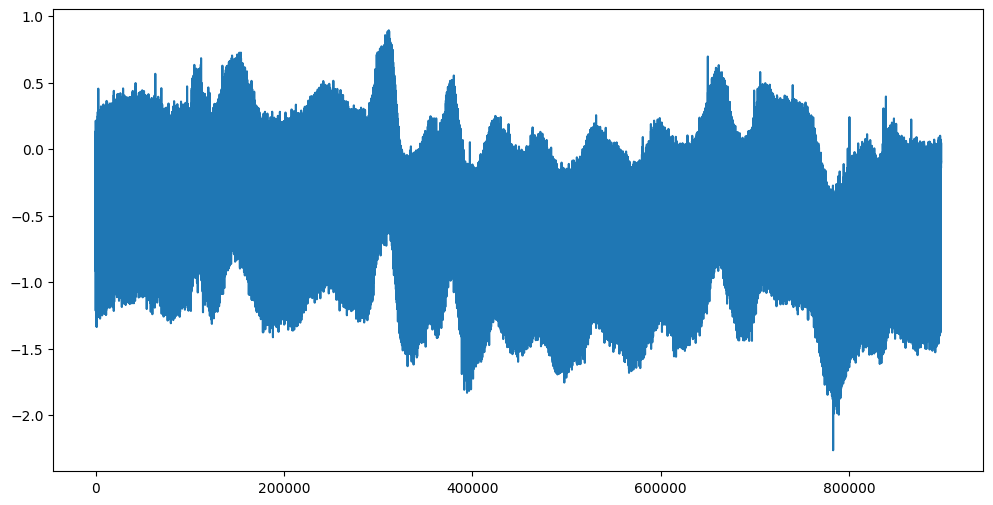

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(accelerometer_raw_df.index, accelerometer_raw_df[channel_name])
plt.show()

## Plot the Raw IEPE Signal

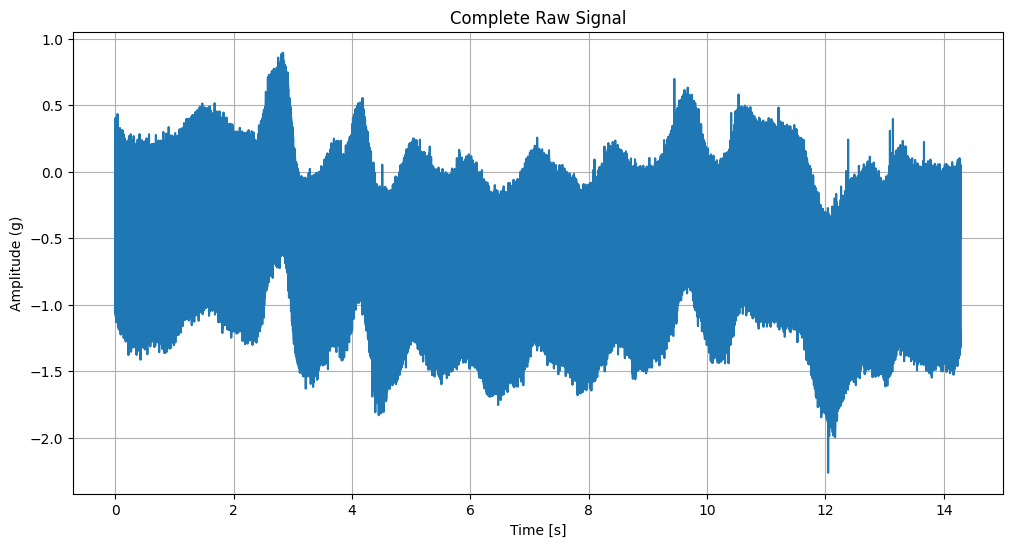

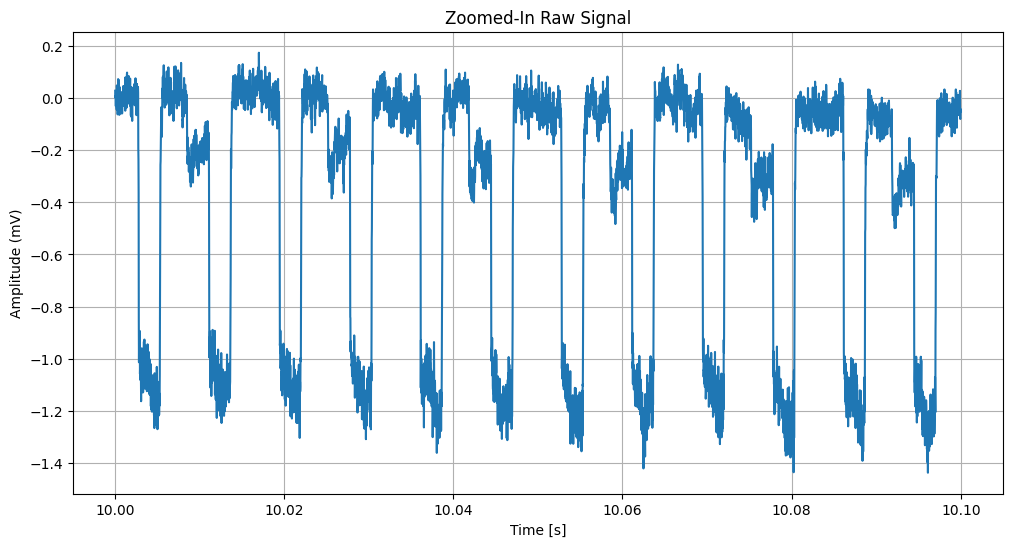

In [19]:


# Complete Raw Signal
plt.figure(figsize=(12, 6))
plt.plot(raw_time, raw_signal)
plt.title(f'Complete Raw Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (g)')
plt.grid(True)
# plt.tight_layout()
plt.show()

viewing_xmin = 10
viewing_xmax = viewing_xmin + .1
x_mask = (raw_time > viewing_xmin) & (raw_time < viewing_xmax)

# Zoomed in X-axis
plt.figure(figsize=(12, 6))
plt.plot(raw_time[x_mask], raw_signal[x_mask])
plt.title(f'Zoomed-In Raw Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (mV)')
plt.grid(True)
# plt.tight_layout()
plt.show()

In [20]:
raise Exception("")

Exception: 

## Time-Mask the IEPE Signal for Power Spectral Density Analysis (Optional)

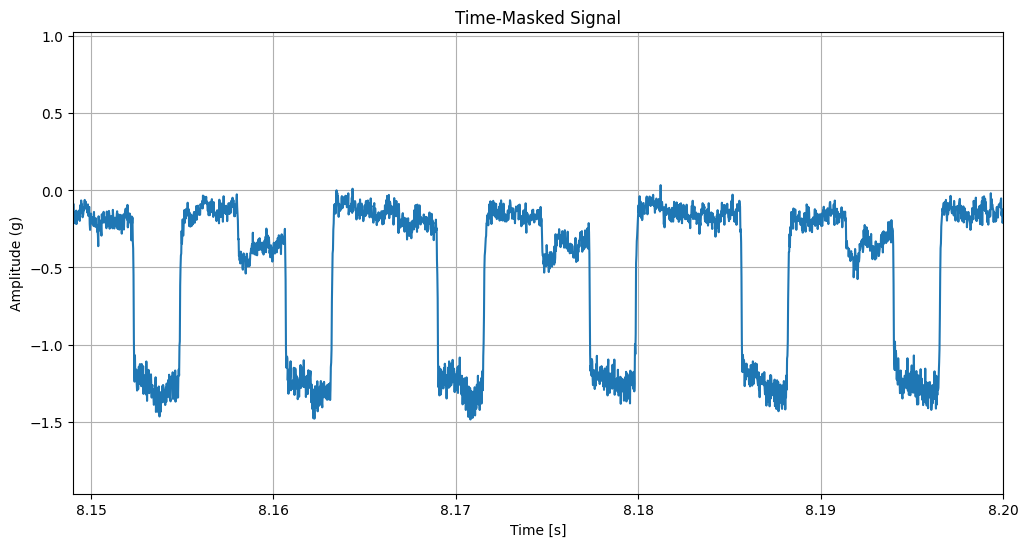

In [ ]:
start_time = 0
end_time = None
mask = (raw_time > start_time)
if end_time is not None:
    mask = (raw_time > start_time) & (raw_time < end_time)

masked_raw_time = raw_time[mask]
masked_raw_signal = raw_signal[mask]

# Plot Time-Masked Raw Signal
plt.figure(figsize=(12, 6))
plt.plot(masked_raw_time, masked_raw_signal)
plt.xlim(left=8.149, right=8.2)
plt.title(f'Time-Masked Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (g)')
plt.grid(True)
plt.show()

## Plot the Fourier Transform and Power Spectrum

Signal RMS: 0.6551347949980514 V
Min Power: -76.36211229506016 dB
Max Power: -27.627857321070234 dB


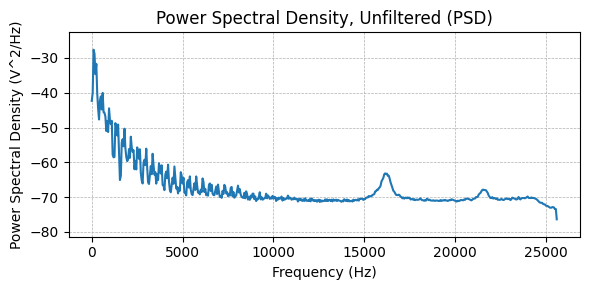

In [22]:
# Compute the Signal RMS
signal_rms = np.sqrt(np.mean(np.square(masked_raw_signal)))
print(f"Signal RMS: {signal_rms} V")

# Compute the Power Spectral Density (PSD)
psd_frequencies, psd = welch(masked_raw_signal, fs=sampling_frequency, nperseg=1024)
# Convert PSD to dB Scale
psd_db = 10 * np.log10(psd)

psd_min = np.min(psd)
psd_max = np.max(psd)

psd_db_min = np.min(psd_db)
psd_db_max = np.max(psd_db)

print(f"Min Power: {psd_db_min} dB")
print(f"Max Power: {psd_db_max} dB")

# Plotting the PSD on a log scale
plt.figure(figsize=(6,3))
# plt.semilogx(psd_frequencies, psd_db)
plt.plot(psd_frequencies, psd_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (V^2/Hz)")
plt.ylim([psd_db_min-5, psd_db_max+5])
plt.title("Power Spectral Density, Unfiltered (PSD)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## STFT Spectrogram

In [23]:
# Compute the spectrogram
frequencies, times, Sxx = spectrogram(masked_raw_signal, sampling_frequency, nperseg=1024)

# Convert the spectrogram to a log scale
Sxx_log = 10 * np.log10(Sxx + 1e-10)

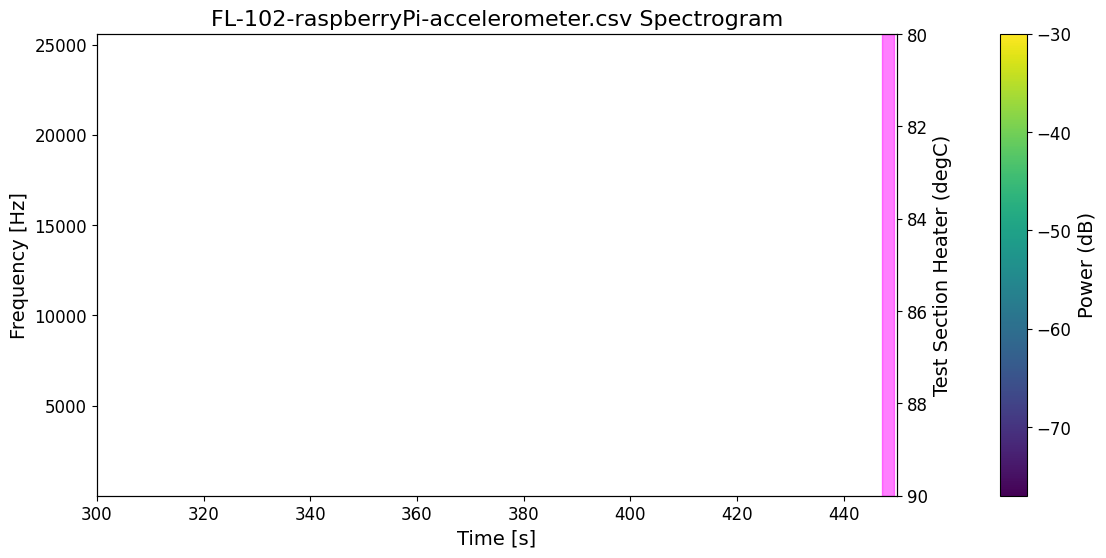

In [24]:
# Create figure and gridspec
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[30, 1], wspace=0.25)  # Adjust width_ratios and wspace for colorbar space

# Main spectrogram plot
ax = fig.add_subplot(gs[0])

# Adjust times array with start_time
times = times + start_time

# min_spectrogram_value_ctrl = psd_db_min
# max_spectrogram_value_ctrl = psd_db_max
min_spectrogram_value_ctrl = -30
max_spectrogram_value_ctrl = -70

spectrogram_xmin = times[0]
spectrogram_xmax = times[-1]
spectrogram_xmin = 300
spectrogram_xmax = 450

spectrogram_image = ax.imshow(
    Sxx_log, 
    extent=[times[0], times[-1], frequencies[-1], frequencies[0]],
    # interpolation='bilinear', 
    cmap='viridis',  # magma, viridis are good choices
    aspect='auto', 
    vmax=max_spectrogram_value_ctrl, 
    vmin=min_spectrogram_value_ctrl
)

# Set axis limits and labels
ax.set_ylim(1, sampling_frequency / 2)
ax.set_ylabel('Frequency [Hz]', fontsize=14)
ax.set_xlabel('Time [s]', fontsize=14)
ax.set_xlim(spectrogram_xmin, spectrogram_xmax)
ax.set_title(f'{accelerometer_filename} Spectrogram', fontsize=16)

# Add the second y-axis plot
ax2 = ax.twinx()

# Plot Test Sectoin Power
ax2.plot(merged_df['Seconds since start'], merged_df['Test Section Heater (degC)'], color='red')
ax2.set_ylabel('Test Section Heater (degC)', fontsize=14)
ax2.set_ylim(bottom=90)
# ax2.plot(merged_df['Seconds since start'], merged_df['Power(W)'], color='orange')
# ax2.set_ylabel('Test Section Power (W)', fontsize=14)
# ax2.set_ylim(bottom=0)

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)

# Colorbar with more space
cbar_ax = fig.add_subplot(gs[1])
cbar = fig.colorbar(spectrogram_image, cax=cbar_ax)
cbar.set_label('Power (dB)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# ax.axvspan(1.3, 2, color='orange', alpha=0.5)
# ax.axvspan(5.2, 5.3, color='orange', alpha=0.5)
# ax.axvspan(14.9, 15, color='orange', alpha=0.5)

# ax.axvline(x=297.1, color='orange', linestyle='--', linewidth=1)

ax.axvspan(447.2, 449.5, color='magenta', alpha=0.5)
ax.axvspan(465.7, 469.8, color='magenta', alpha=0.5)
ax.axvspan(517.5, 517.6, color='magenta', alpha=0.5)
ax.axvspan(562.1, 562.2, color='magenta', alpha=0.5)
ax.axvspan(594.5, 603.7, color='magenta', alpha=0.5)


gas_color = 'magenta'

# ax.axvline(x=447.2, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=447.4, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=447.6, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=447.8, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=448.0, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=448.3, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=448.4, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=448.6, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=448.8, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=449.0, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=449.3, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=449.5, color=gas_color, linestyle='--', linewidth=1)


# ax.axvline(x=465.7, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=465.9, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=466.2, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=466.4, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=466.6, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=466.8, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=467.0, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=467.4, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=467.6, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=467.8, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=468.1, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=468.4, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=468.8, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=469.1, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=469.4, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=469.8, color=gas_color, linestyle='--', linewidth=1)


# ax.axvline(x=517.5, color=gas_color, linestyle='--', linewidth=1)


# ax.axvline(x=562.1, color=gas_color, linestyle='--', linewidth=1)


# ax.axvline(x=594.5, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=597.2, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=598.8, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=599.6, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=599.8, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=600.1, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=600.3, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=600.7, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=601.0, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=601.2, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=601.4, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=601.6, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=602.1, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=602.2, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=602.4, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=602.6, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=602.9, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=603.2, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=603.7, color=gas_color, linestyle='--', linewidth=1)
# ax.axvline(x=608.5, color=gas_color, linestyle='--', linewidth=1)

# # Annotate with an arrow pointing to the vertical line
# ax.annotate(
#     'Upstream Gas Released', 
#     xy=(594.5, ax.get_ylim()[1] * 0.15),  # The arrow's position on the line
#     xytext=(582, ax.get_ylim()[1] * 0.25),  # The text position
#     arrowprops=dict(arrowstyle='->', color='magenta'),
#     color='magenta',
#     fontsize=12
# )


ax.axvspan(246, 293, color='orange', linestyle='--', linewidth=1, alpha=0.3)

# Add a vertical line
ax.axvline(x=731, color='purple', linestyle='--', linewidth=1)

# Annotate with an arrow pointing to the vertical line
# ax.annotate(
#     'In-channel boiling\nstarts at 731s', 
#     xy=(731, ax.get_ylim()[1] * 0.15),  # The arrow's position on the line
#     xytext=(740, ax.get_ylim()[1] * 0.05),  # The text position
#     arrowprops=dict(arrowstyle='->', color='purple'),
#     color='purple',
#     fontsize=10
# )

# Add a message to the right of the line
# ax.text(255, ax.get_ylim()[1] * 0.5, 'Intermittent Downstream Boiling', color='#ff8c00', fontsize=12)

# ax.annotate(
#     'Intermittent Downstream Boiling', 
#     xy=(260, ax.get_ylim()[1] * 0.15),  # The arrow's position on the line
#     xytext=(260, ax.get_ylim()[1] * 0.05),  # The text position
#     arrowprops=dict(arrowstyle='->', color='purple'),
#     color='purple',
#     fontsize=10
# )

# Show the plot
plt.show()

## Checkpoint Before Proceeding with CWT/DWT Analysis

In [25]:
try:
    while True:
        user_input = input("Do you want to run CWT/DWT Analysis? Type 'Y/n' to continue: ")
        if user_input.lower() == 'n':
            raise Exception("Execution stopped by user.")
        elif user_input.lower() == 'y':
            break
except Exception as e:
    print(e)
    # Prevent further cells from executing
    raise

## Generate a Synthetic Signal Based on the Power Spectrum of the Time-Masked Raw Signal to Compare Spectrogram Results with

[876.04204013 876.64229791 877.24214497 ...  17.44678029  17.42976359
  17.41273026]
[-0.95333378-0.30191837j -0.21698192-0.97617562j -0.79868996-0.60174275j
 ... -0.89291172-0.45023178j  0.29119252-0.95666447j
  0.27606015+0.96114036j]
[7.61257431e-05 4.88616495e-04 1.26052318e-03 1.17595684e-03
 6.40229370e-04 4.81793099e-04 2.09787754e-04 5.06309683e-05
 3.17260165e-05 5.37867894e-05 6.38768018e-05 5.97970397e-05
 6.88529106e-05 4.24091569e-05 2.57086394e-05 1.91742074e-05
 1.25606443e-05 1.20753459e-05 1.55778781e-05 2.52172614e-05
 1.95070628e-05 1.40650185e-05 1.18158143e-05 4.71715407e-06
 1.68243345e-06 4.12397271e-06 9.97054732e-06 9.89955029e-06
 8.15940999e-06 8.45688594e-06 3.76660675e-06 7.80168494e-07
 1.15529211e-06 3.19987816e-06 4.07087193e-06 4.60966558e-06
 6.38081316e-06 3.83444280e-06 1.63512878e-06 1.20025681e-06
 1.42815042e-06 1.95055289e-06 2.41852014e-06 3.96905229e-06
 3.16998394e-06 2.20084083e-06 1.82665687e-06 1.09431376e-06
 9.12024546e-07 1.15887126e-06 

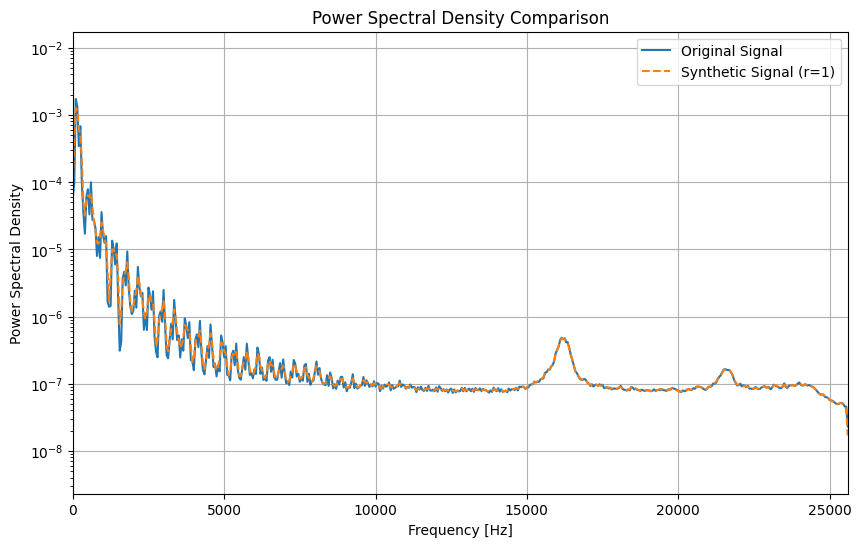

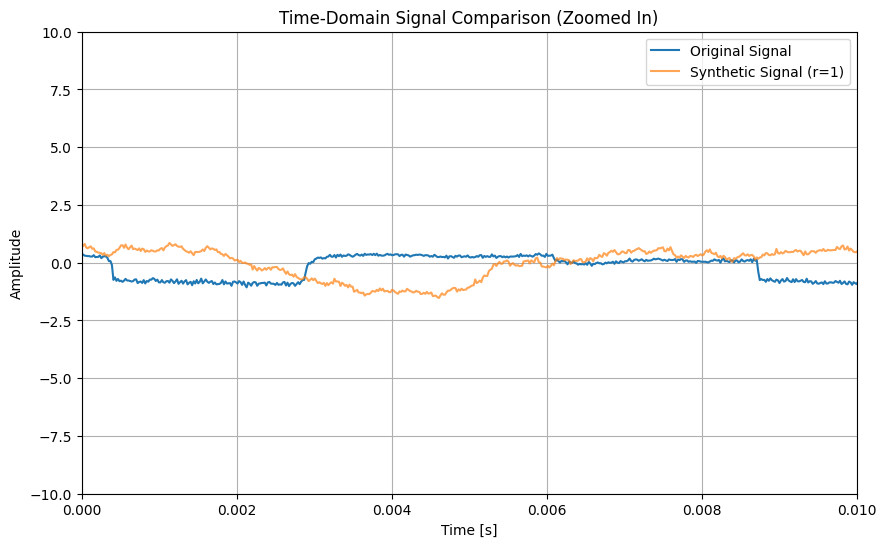

In [26]:
# Define the resolution factor
r = 1  # Change 'r' to your desired resolution factor

# Original signal parameters
N = len(masked_raw_signal)
dt = 1. / sampling_frequency
duration = masked_raw_time[-1] - masked_raw_time[0] + dt

# New sampling frequency and parameters
sampling_frequency_new = sampling_frequency * r
dt_new = 1. / sampling_frequency_new
N_new = int(duration * sampling_frequency_new)

# New time vector
time_synthetic = np.linspace(masked_raw_time[0], masked_raw_time[-1], N_new, endpoint=False)

# Frequency vectors
freqs_new = np.fft.fftfreq(N_new, d=dt_new)
freqs_new_positive = freqs_new[:N_new // 2 + 1]

# Interpolate PSD to new frequencies up to the original Nyquist frequency
max_freq = sampling_frequency / 2
mask = freqs_new_positive <= max_freq
freqs_interp = freqs_new_positive[mask]
interp_psd = interp1d(psd_frequencies, psd, kind='linear', bounds_error=False, fill_value=0)
psd_interp = interp_psd(freqs_interp)

# Compute amplitude spectrum
# The factor of 2 accounts for the energy in negative frequencies
# The sqrt(N_new) factor is to match the scaling of np.fft.fft
amplitude_spectrum = np.zeros(len(freqs_new_positive))
amplitude_spectrum[mask] = np.sqrt(1/2 * psd_interp * sampling_frequency_new * N_new)
print(amplitude_spectrum)

# Generate random phases
np.random.seed(0)  # For reproducibility; remove or change for different results
random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs_new_positive)))
print(random_phases)

# Construct the positive frequency components
fft_positive = amplitude_spectrum * random_phases

# Construct the full FFT spectrum with Hermitian symmetry
if N_new % 2 == 0:
    # N_new is even
    fft_synthetic = np.zeros(N_new, dtype=complex)
    fft_synthetic[0] = fft_positive[0].real  # DC component (real-valued)
    fft_synthetic[1:N_new // 2] = fft_positive[1:-1]
    fft_synthetic[N_new // 2] = fft_positive[-1].real  # Nyquist component (real-valued)
    fft_synthetic[N_new // 2 + 1:] = np.conj(fft_positive[1:-1][::-1])
else:
    # N_new is odd
    fft_synthetic = np.zeros(N_new, dtype=complex)
    fft_synthetic[0] = fft_positive[0].real  # DC component (real-valued)
    fft_synthetic[1:(N_new + 1) // 2] = fft_positive[1:]
    fft_synthetic[(N_new + 1) // 2:] = np.conj(fft_positive[1:][::-1])

# Inverse FFT to get the synthetic signal
synthetic_signal = np.fft.ifft(fft_synthetic).real

# Compute the PSD of the synthetic signal
f_synthetic, Pxx_synthetic = welch(synthetic_signal, fs=sampling_frequency_new, nperseg=1024)

print(Pxx_synthetic)

# Plot the PSDs
plt.figure(figsize=(10, 6))
plt.semilogy(psd_frequencies, psd, label='Original Signal')
plt.semilogy(f_synthetic, Pxx_synthetic, label=f'Synthetic Signal (r={r})', linestyle='--')
plt.xlim(0, sampling_frequency/2)
plt.ylim(psd.min()/10, psd.max()*10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Zoom in on the time-domain signals
plt.figure(figsize=(10, 6))
plt.plot(masked_raw_time, masked_raw_signal, label='Original Signal')
plt.plot(time_synthetic, synthetic_signal, label=f'Synthetic Signal (r={r})', alpha=0.7)
plt.xlim(start_time, start_time + .01)  # Adjust the limits as needed
plt.ylim(-10, 10)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time-Domain Signal Comparison (Zoomed In)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
raise Exception("")

Exception: 

## Time-Mask the Signal for Wavelet Analysis (Recommended for Sake of Computation Time)

original
(511999,)
(511999,)


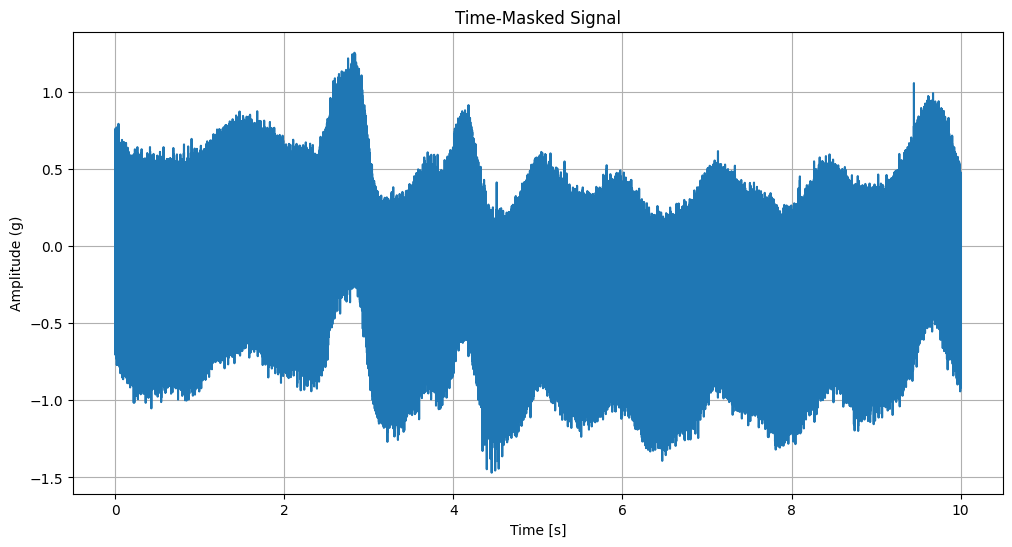

In [34]:
start_time = 0
end_time = 10

original_or_synthetic = ""
while True:
    # Specify whether to generate the scalogram using the orignal or synthetic data
    original_or_synthetic = input("Specify whether to generate the scalogram using the orignal or synthetic data. Type \"original\" or \"synthetic\": ")
    print(original_or_synthetic)

    if original_or_synthetic == "original" or original_or_synthetic == "synthetic":
        break
    else:
        raise Exception("Invalid input. Try again.")

if original_or_synthetic == "original":
    # Process original signal
    mask = (raw_time > start_time)
    if end_time is not None:
        mask = (raw_time > start_time) & (raw_time < end_time)
    time = raw_time[mask]
    signal = raw_signal[mask]
    signal = signal - np.mean(signal)  # Remove any y-axis offset

elif original_or_synthetic == "synthetic":
    # Synthetic signal (for comparison)
    mask = (time_synthetic > start_time)
    if end_time is not None:
        mask = (time_synthetic > start_time) & (time_synthetic < end_time)
    time = time_synthetic[mask]
    signal = synthetic_signal[mask]

print(time.shape)
print(signal.shape)


# Plot Time-Masked Raw Signal
plt.figure(figsize=(12, 6))
plt.plot(time, signal)
plt.title(f'Time-Masked Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (g)')
plt.grid(True)
plt.show()

## Filter the Signal for Wavelet Analysis (Optional)

In [35]:
filter_signal = ""
while filter_signal != "y":
    # Specify the file path directly
    filter_signal = input("Would you like to filter the signal? (Y/n)")

    if filter_signal.lower() == "y":
        # Define the bandpass filter parameters
        lowcut = 5000  # Lower frequency (Hz)
        highcut = 25000  # Upper frequency (Hz)

        # Butterworth bandpass filter design
        def butter_bandpass(lowcut, highcut, fs, order=20):
            nyquist = 0.5 * fs  # Nyquist frequency
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = scipy.signal.butter(order, [low, high], btype='band')
            return b, a

        # Apply the filter to the signal
        def bandpass_filter(data, lowcut, highcut, fs, order=5):
            b, a = butter_bandpass(lowcut, highcut, fs, order=order)
            y = scipy.signal.filtfilt(b, a, data)
            return y

        # Filter the signal
        signal = bandpass_filter(signal, lowcut, highcut, sampling_frequency) 
        break

    elif filter_signal.lower() == "n":
        break

if filter_signal == "y":
    # Plot the filtered signal
    plt.figure(figsize=(12, 6))
    plt.plot(time, signal, color="r")
    plt.title(f'Complete Filtered Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

    # Plot the filtered signal (zoomed in)
    zoom_mask = (time > start_time) & (time < (start_time + .02))

    plt.figure(figsize=(12, 6))
    plt.plot(time[zoom_mask], signal[zoom_mask], color="r")
    plt.title(f'Filtered Signal (Zoomed)')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

    # Re-compute and plot the power spectrum for the filtered signal
    psd_frequencies, psd = welch(signal, fs=sampling_frequency, nperseg=8192)
    # Convert PSD to dB Scale
    psd_db = 10 * np.log10(psd)

    psd_min = np.min(psd)
    psd_max = np.max(psd)

    psd_db_min = np.min(psd_db)
    psd_db_max = np.max(psd_db)

    # Plotting the PSD on a log scale
    plt.figure(figsize=(6,3))
    plt.semilogx(psd_frequencies, psd_db)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (V^2/Hz)")
    # plt.ylim([psd_db_min, psd_db_max])
    plt.title("Power Spectral Density, Unfiltered (PSD)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

## Compute Wavelet Transform

In [36]:
# Listing all available wavelets
all_wavelets = pywt.wavelist()  # Lists all discrete and continuous wavelets
discrete_wavelets = pywt.wavelist(kind='discrete')
continuous_wavelets = pywt.wavelist(kind='continuous')

print("Discrete wavelets:", discrete_wavelets)
print("Continuous wavelets:", continuous_wavelets)

# Declare the mother wavelet
wavelet = 'morl'
wavelet_obj = pywt.ContinuousWavelet(wavelet)
print()
print(wavelet_obj)

Discrete wavelets: ['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']
Continuous wave

In [37]:
# Define the frequency range you want to capture
lowest_frequency = 1000  # Hz (adjust this as needed)
highest_frequency = sampling_frequency/2  # Nyquist frequency

# Compute the normalized frequency range
lowest_frequency_normalized = lowest_frequency / sampling_frequency
highest_frequency_normalized = highest_frequency / sampling_frequency

# Calculate the corresponding scales
highest_scale = pywt.frequency2scale(wavelet, lowest_frequency_normalized)
lowest_scale = pywt.frequency2scale(wavelet, highest_frequency_normalized)
# scales = np.arange(1, 128)

num_scales = 256  # Adjustable resolution

normalized_frequencies = np.linspace(highest_frequency_normalized, lowest_frequency_normalized, num_scales)
scales = [pywt.frequency2scale(wavelet, frequency) for frequency in normalized_frequencies]

scales_converted2frequencies = [pywt.scale2frequency(wavelet, scale)/sampling_period for scale in scales]
print(f"Scales: {scales}")
print(f"Scales converted to frequencies: {scales_converted2frequencies}")

# Perform the Continuous Wavelet Transform
coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=sampling_period)

# Verify the frequency range
print(f"Frequency range: {frequencies[-1]:.2f} Hz to {frequencies[0]:.2f} Hz")

Scales: [1.625, 1.6311467879691668, 1.637340254663813, 1.6435809338281286, 1.6498693673748464, 1.6562061055421062, 1.662591707053953, 1.6690267392845584, 1.675511778426271, 1.6820474096616025, 1.688634227339252, 1.6952728351542838, 1.7019638463325708, 1.7087078838196244, 1.715505580473931, 1.7223575792649222, 1.7292645334757069, 1.7362271069107038, 1.7432459741083075, 1.7503218205587345, 1.7574553429271982, 1.76464724928256, 1.771898259331621, 1.7792091046592131, 1.7865805289742553, 1.794013288361957, 1.8015081515423397, 1.8090659001352665, 1.816687328932172, 1.8243732461746893, 1.8321244738403795, 1.8399418479357763, 1.8478262187969654, 1.8557784513979247, 1.8637994256668617, 1.8718900368107882, 1.8800511956485877, 1.8882838289528325, 1.8965888798006207, 1.904967307933714, 1.9134200901282623, 1.921948220574415, 1.9305527112661311, 1.9392345924015064, 1.9479949127939502, 1.95683474029456, 1.9657551622260467, 1.9747572858285831, 1.983842238717959, 1.9930111693564434, 2.002265247536761, 

## CWT Results

In [38]:
abs_coefficients = np.abs(coefficients)  # Take the absolute value of the coefficients to get the magnitude
# print(coefficients)
# print(abs_coefficients)
abs_coefficients_copy = np.abs(coefficients)
power = np.abs(coefficients) ** 2
epsilon = 1e-10
power_db = 10 * np.log10(power+epsilon)

print(f"Frequencies Array: {frequencies.shape}")
print(f"Coefficients Array: {coefficients.shape}")

max_coeff_value = abs(coefficients.max())
print(f"Maximum Coefficients Value: {max_coeff_value}")
min_power = power.min()
max_power = power.max()
min_power_db = power_db.min()
print(f"Min Power: {min_power_db}")
max_power_db = power_db.max()
print(f"Max Power: {max_power_db}")

Frequencies Array: (256,)
Coefficients Array: (256, 511999)
Maximum Coefficients Value: 2.0057721359839498
Min Power: -99.9999999996163
Max Power: 6.045631876829638


## Full Scalogram Plotted with Filled Contours Method (adjust max_magnitude as needed for contrast)

In [42]:
# Adjust the values for max_magnitude and n_color_contours to manipulate graph contrast and resolution, respectively
min_value = min_power_db
max_value = max_power_db
print(f"Min Scalogram Value: {min_value}")
print(f"Max Scalogram Value: {max_value}")
n_color_contours = 10

full_scalogram_levels = np.linspace(min_value, max_value, n_color_contours, endpoint=True)

Min Scalogram Value: -99.9999999996163
Max Scalogram Value: 6.045631876829638


masked_power_db shape: (256, 511999)


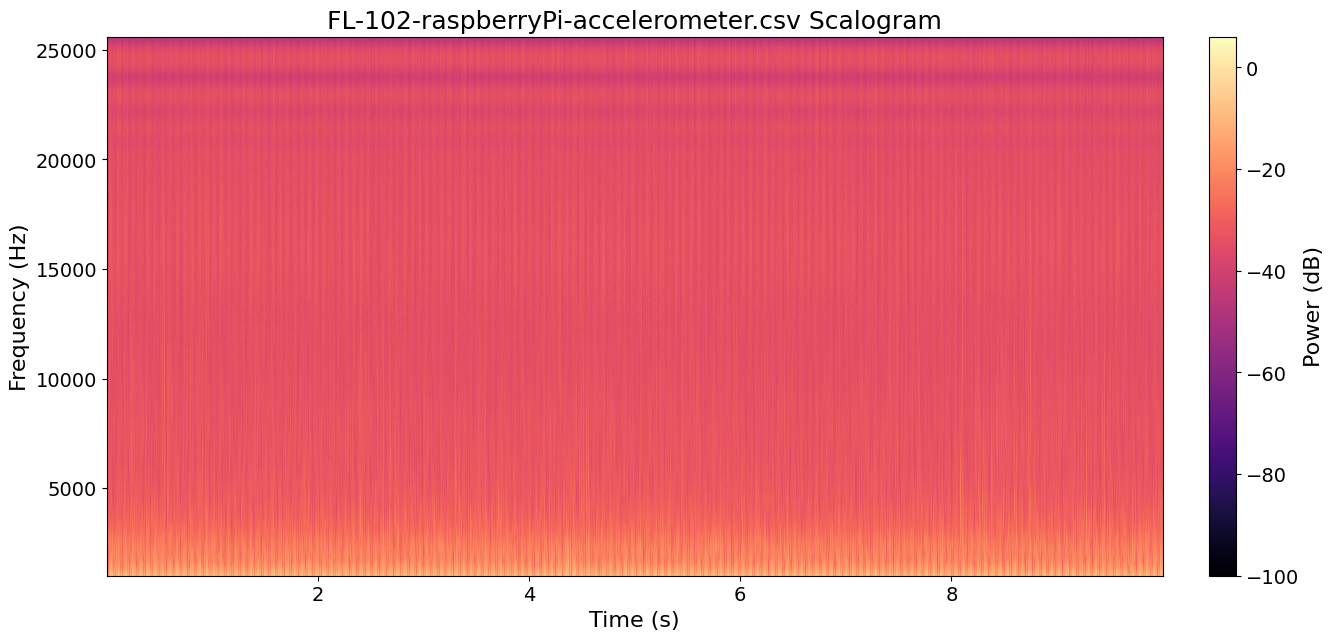

In [43]:
title_size = 18
label_size = 16
tick_size = 14

# Find the indices of frequencies within the desired range
frequency_indices = np.where((frequencies >= lowest_frequency) & (frequencies <= highest_frequency))[0]

# Ensure frequency_indices is 1D and properly formatted
frequency_indices = np.ravel(frequency_indices)

# Filter the frequencies and coefficients accordingly
masked_frequencies = frequencies[frequency_indices]

# Specify the desired timeframe range
start_timeframe = start_time
end_timeframe = end_time
# start_timeframe = 205
# end_timeframe = 210

# Find the indices of the time within the desired range
if end_timeframe is not None:
    time_indices = np.where((time >= start_timeframe) & (time <= end_timeframe))[0]
else:
    time_indices = np.where((time >= start_timeframe))[0]

# Ensure time_indices is 1D and properly formatted
time_indices = np.ravel(time_indices)

masked_timeframe = time[time_indices]

# Corrected indexing for power_db
# Using frequency_indices and time_indices to slice power_db
masked_power_db = power_db[np.ix_(frequency_indices, time_indices)]
print("masked_power_db shape:", masked_power_db.shape)


fig, ax1 = plt.subplots(figsize=(16, 7))

# TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
scalogram_image = ax1.imshow(
    masked_power_db, 
    extent=[masked_timeframe[0], masked_timeframe[-1], masked_frequencies[-1], masked_frequencies[0]],  # TODO: I think the y-scale is messed up on the graph because the y-axis of masked_power_db is not linear 
    # interpolation='bilinear', 
    cmap='magma', 
    aspect='auto', 
    vmax=max_value, 
    vmin=min_value
)

ax1.set_ylabel('Frequency (Hz)', fontsize=label_size)
ax1.set_xlabel('Time (s)', fontsize=label_size)
ax1.set_title(f'{accelerometer_filename} Scalogram', fontsize=title_size)

# Format the y-axis to show whole numbers instead of scientific notation
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# ax2 = ax1.twinx()
# ax2.set_yscale('log')
# ax2.set_ylabel('Scales')
# ax2.tick_params(axis='y', color='b')
# ax2.set_ylim(scales[0], scales[-1])
# ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

cbar = fig.colorbar(scalogram_image, ax=[ax1], fraction=0.05, pad=0.04)
cbar.set_label('Power (dB)', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size) 

plt.tick_params(axis='both', which='major', labelsize=tick_size)

In [44]:
raise Exception()

Exception: 

In [ ]:
# # Find the indices of frequencies within the desired range
# frequency_indices = np.where((frequencies >= lowest_frequency) & (frequencies <= highest_frequency))[0]

# # Ensure frequency_indices is 1D and properly formatted
# frequency_indices = np.ravel(frequency_indices)

# # Filter the frequencies and coefficients accordingly
# masked_frequencies = frequencies[frequency_indices]

# print("power_db shape:", power_db.shape)  # (16, 1279999)
# print("frequency_indices:", frequency_indices)  # Should be 1D array

# # Specify the desired timeframe range
# start_timeframe = start_time
# end_timeframe = end_time
# # start_timeframe = 205
# # end_timeframe = 210

# # Find the indices of the time within the desired range
# if end_timeframe is not None:
#     time_indices = np.where((time >= start_timeframe) & (time <= end_timeframe))[0]
# else:
#     time_indices = np.where((time >= start_timeframe))[0]

# # Ensure time_indices is 1D and properly formatted
# time_indices = np.ravel(time_indices)

# masked_timeframe = time[time_indices]

# print("time_indices:", time_indices)  # Should be 1D array

# # Corrected indexing for power_db
# # Using frequency_indices and time_indices to slice power_db
# masked_power_db = power_db[np.ix_(frequency_indices, time_indices)]
# print(power_db)

# print("masked_power_db shape:", masked_power_db.shape)


# fig, ax1 = plt.subplots(figsize=(16, 8))

# # TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
# scalogram_image = ax1.pcolormesh(
#     time, frequencies, masked_power_db, 
#     cmap='jet',
#     shading='gouraud',  # or 'flat' if you want exact cell boundaries
#     vmax=max_value,
#     vmin=min_value
# )

# ax1.set_ylabel('Frequency (Hz)')
# ax1.set_xlabel('Time (s)')
# ax1.set_title('Scalogram (Wavelet Transform)')

# # Format the y-axis to show whole numbers instead of scientific notation
# ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# ax2 = ax1.twinx()
# ax2.set_ylabel('Scales')
# ax2.tick_params(axis='y', color='b')
# ax2.set_ylim(scales[0], scales[-1])
# ax2.invert_yaxis()

# # Adjust the space between the graph and colorbar
# plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# cbar = fig.colorbar(scalogram_image, ax=[ax1, ax2], fraction=0.05, pad=0.04)
# cbar.set_label('Power (dB)')

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.contourf(time, frequencies, power_db, levels=full_scalogram_levels, cmap='jet', extend='both')
# scalogram = ax1.pcolormesh(time, frequencies, power_db, cmap='jet', shading='auto')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
# ax1.set_yscale('log')
# ax1.set_xlim([1, 1.05])

ax2 = ax1.twinx()
# ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Power')

# # Create a third axis to plot "time" vs "signal" with a linear y-axis
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Move the third axis further out
# ax3.set_ylabel('Signal', color='g')
# ax3.plot(time, signal, color='g')  # Plot time vs signal
# ax3.tick_params(axis='y', labelcolor='g')
# ax3.set_yscale('linear')  # Ensure the y-axis is linear

plt.show()

## Time-Masked Scalogram (adjust xmin, xmax, max_magnitude to zoom and adjust contrast)

In [ ]:
xmin = 43.02  # Default 0
xmax = xmin + 0.01  # Use none to designate no end
n_color_contours = 64

mask = time > xmin
if xmax:
    mask = mask & (time < xmax)

masked_time_array = time[mask]
masked_power_array = power[:, mask]
masked_power_db_array = power_db[:, mask]
masked_signal = signal[mask]

levels = np.linspace(min_value, max_value, n_color_contours, endpoint=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

zoom_mask = (time > xmin) & (time < xmax)
ax.plot(time[zoom_mask], signal[zoom_mask])

# Adjust the space between the graph and the right edge to match the contourf() plot
plt.subplots_adjust(right=0.85)

plt.show()



fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.contourf(masked_time_array, frequencies, masked_power_db_array, levels=levels, cmap='jet', extend='both')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Power')

plt.show()

In [ ]:
# # Define the bandpass filter parameters
# lowcut = 1000  # Lower frequency (Hz)
# highcut = 5000  # Upper frequency (Hz)

# # Butterworth bandpass filter design
# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyquist = 0.5 * fs  # Nyquist frequency
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = scipy.signal.butter(order, [low, high], btype='band')
#     return b, a

# # Apply the filter to the signal
# def bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = scipy.signal.filtfilt(b, a, data)
#     return y

# # Filter the signal
# filtered_signal = bandpass_filter(signal, lowcut, highcut, sampling_frequency)

# plt.figure(figsize=(10, 6))
# plt.plot(time[zoom_mask], filtered_signal[zoom_mask], label='Filtered Signal (Bandpass)', color='r')
# plt.title(f'Filtered Signal (Bandpass: {lowcut}Hz - {highcut}Hz)')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

## Statistical Analysis of Time-Masked Signal

In [ ]:
N = np.size(masked_signal)
mean = np.mean(masked_signal)
variance = np.var(masked_signal)  # Population variance
st_dev = math.sqrt(variance)
shapiro_test = stats.shapiro(masked_signal)
ks_test = stats.kstest(masked_signal, 'norm')
anderson_test = stats.anderson(masked_signal, dist='norm')

print(f"# of Points: {N}")
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Shapiro Test p-value: {shapiro_test.pvalue}")
print(f"K-S Test p-value: {ks_test.pvalue}")
print(anderson_test)

# # Create a histogram
# plt.figure(figsize=(12,5))
# plt.hist(signal, bins=200, edgecolor='black', alpha=0.7)
# plt.title('Histogram of the Data Distribution')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.xlim([mean-3*st_dev,mean+3*st_dev])
# plt.show()

# # KDE plot to smooth over the low-resolution signal
# sns.kdeplot(signal, shade=True)
# plt.title('KDE Plot of Low-Resolution Signal')
# plt.xlabel('Value')
# plt.ylabel('Density')
# # plt.axvline(x=mean-2*st_dev, color='r', linestyle='--',)
# plt.axvline(x=mean-st_dev, color='r', linestyle='--',)
# plt.axvline(x=mean, color='r', linestyle='--',)
# plt.axvline(x=mean+st_dev, color='r', linestyle='--',)
# # plt.axvline(x=mean+2*st_dev, color='r', linestyle='--',)
# plt.show()

# Q-Q Plot: If the data is normally distributed, the points in the Q-Q plot will roughly follow a straight diagonal line.
stats.probplot(masked_signal, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [ ]:
# # Calculate mean and standard deviation
# mean = np.mean(signal)
# std_dev = np.std(signal)

# # Perform KDE using scipy's gaussian_kde
# kde = gaussian_kde(signal)

# # Create an x-axis range for plotting and integration
# x = np.linspace(min(signal), max(signal), 1000)

# # Evaluate the KDE for the x-axis
# kde_values = kde(x)

# # Plot the KDE
# plt.plot(x, kde_values, label='KDE')
# plt.fill_between(x, kde_values, alpha=0.5)

# # Add vertical lines for ±1σ, ±2σ, and ±3σ
# plt.axvline(mean - std_dev, color='green', linestyle='--', label='1σ')
# plt.axvline(mean + std_dev, color='green', linestyle='--')
# plt.axvline(mean - 2*std_dev, color='blue', linestyle='--', label='2σ')
# plt.axvline(mean + 2*std_dev, color='blue', linestyle='--')
# plt.axvline(mean - 3*std_dev, color='red', linestyle='--', label='3σ')
# plt.axvline(mean + 3*std_dev, color='red', linestyle='--')

# # Define the KDE function for integration
# def kde_function(x_val):
#     return kde(x_val)

# # Numerically integrate the KDE for 1σ, 2σ, and 3σ
# area_1sigma, _ = quad(kde_function, mean - std_dev, mean + std_dev)
# area_2sigma, _ = quad(kde_function, mean - 2*std_dev, mean + 2*std_dev)
# area_3sigma, _ = quad(kde_function, mean - 3*std_dev, mean + 3*std_dev)

# # Integrate the entire KDE (total area)
# total_area, _ = quad(kde_function, min(signal), max(signal))

# # Calculate the percentage of area within 1σ, 2σ, and 3σ
# percentage_within_1sigma = (area_1sigma / total_area) * 100
# percentage_within_2sigma = (area_2sigma / total_area) * 100
# percentage_within_3sigma = (area_3sigma / total_area) * 100

# # Add title and labels
# plt.title(f"KDE Plot with {percentage_within_1sigma:.2f}% within 1σ, "
#           f"{percentage_within_2sigma:.2f}% within 2σ, "
#           f"{percentage_within_3sigma:.2f}% within 3σ")
# plt.legend()

# # Show plot
# plt.show()

# # Print the results
# print(f"Percentage of area within 1 standard deviation: {percentage_within_1sigma:.2f}%")
# print(f"Percentage of area within 2 standard deviations: {percentage_within_2sigma:.2f}%")
# print(f"Percentage of area within 3 standard deviations: {percentage_within_3sigma:.2f}%")

In [ ]:
# Calculate the power spectrum of the wavelet transform (magnitude squared of coefficients)
power_spectrum = abs_coefficients_copy[:] ** 2

# Compute the mean power spectrum of the baseline
masked_mean_power_spectrum  = np.mean(masked_power_array, axis=1)

dof = 2  # DOF=2 because in a complex-valued signal, both the real and imaginary parts contribute to the power

# Using chi2.cdf to convert power spectrum values to confidence levels
# chi2.cdf returns the probability that a chi-squared random variable with 'dof' DOF 
# will be less than or equal to a given value (power in this case)
confidence_array = chi2.cdf(power_spectrum / masked_mean_power_spectrum[:, np.newaxis], dof)
masked_confidence_array = chi2.cdf(masked_power_array / masked_mean_power_spectrum[:, np.newaxis], dof)

# Compute the power levels corresponding to an n% confidence level at each frequency/scale
confidence_percentage = 99.0
confidence = confidence_percentage / 100
confidence_level_power = chi2.ppf(confidence, df=2) * masked_mean_power_spectrum

# Convert confidence level from power to magnitude by taking the square root
confidence_level_magnitude = np.sqrt(confidence_level_power)

"""Curve Fit for Noise Following a Power Law"""
# Mask Frequencies above the Sensor's Level of Attenuation
max_sensor_frequency = 10000
mask = frequencies < 10000

# Define the power-law function
def power_law(f, k, alpha):
    return k * f ** (-alpha)

# Initial guess for k and alpha
initial_guess = [1e-3, 1]

# Perform curve fitting
params, covariance = curve_fit(power_law, frequencies[mask], masked_mean_power_spectrum[mask], p0=initial_guess)
k_fitted, alpha_fitted = params
print(f"Fitted k: {k_fitted}")
print(f"Fitted alpha: {alpha_fitted}")

# Compute the fitted power values
P_fitted = power_law(frequencies, k_fitted, alpha_fitted)

# Plot the original data and the fitted curve
plt.figure()
plt.plot(frequencies, masked_mean_power_spectrum, label='Original Data')
plt.plot(frequencies, P_fitted, 'r', label='Fitted Curve')
plt.plot(frequencies, confidence_level_power, color='gray', alpha=0.3, label=f'{confidence_percentage}% Confidence Power')
plt.axvline(max_sensor_frequency, color='orange', linestyle='--', label="Max Sensor Frequency")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power vs. Frequency with Fitted Power Law')
plt.legend()
plt.show()

# Visualize the baseline power and the confidence intervals for reference
plt.plot(frequencies, masked_mean_power_spectrum, label='Mean Power')
plt.plot(frequencies, P_fitted, 'r', label='Fitted Curve')
plt.plot(frequencies, confidence_level_power, color='gray', alpha=0.3, label=f'{confidence_percentage}% Confidence Power')
plt.axvline(max_sensor_frequency, color='orange', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.xlim([0, 100])
plt.gca().set_ylim(bottom=0)
plt.show()

In [ ]:
# Get the confidences for every scale for a magnitude level on the scalogram
def get_confidence_levels(magnitude: float, mean_power_spectrum, dof=2):
    if magnitude > 1 or magnitude < 0:
        raise Exception("Magnitude must be a number between 0 and 1")
    n_scales = mean_power_spectrum.shape[0]
    magnitude_coefficients = np.full(n_scales, magnitude)
    power_spectrum = magnitude_coefficients ** 2
    confidence_levels = chi2.cdf(power_spectrum / mean_power_spectrum, dof)
    return confidence_levels

confidence_levels_for_certain_magnitude = get_confidence_levels(magnitude=0.01, mean_power_spectrum=masked_mean_power_spectrum)
np.set_printoptions(precision=15)
print(confidence_levels_for_certain_magnitude)
np.set_printoptions(precision=8)

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Overlay confidence contours (in magnitude)
scalogram = ax1.contourf(time, frequencies, power, levels=full_scalogram_levels, cmap='jet', extend='both')
# Overlay the single filled contour
contour = ax1.contourf(time, frequencies, confidence_array, levels=[0.999999999999998, 1], colors='white', alpha=.5)

ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Magnitude')
# ax1.set_xlim([12.2, 12.21])
plt.show()

## Full Scalogram Plotted with Colormesh Method

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.pcolormesh(time, frequencies, power, cmap='jet', shading='auto')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Magnitude')

plt.show()